In [8]:
import neurogym as ngym 
import matplotlib.pyplot as plt
# Enviroment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=110,
                       seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n
act_size

3

inputs.shape = (100, 110, 3)
labels.shape = (100, 110)


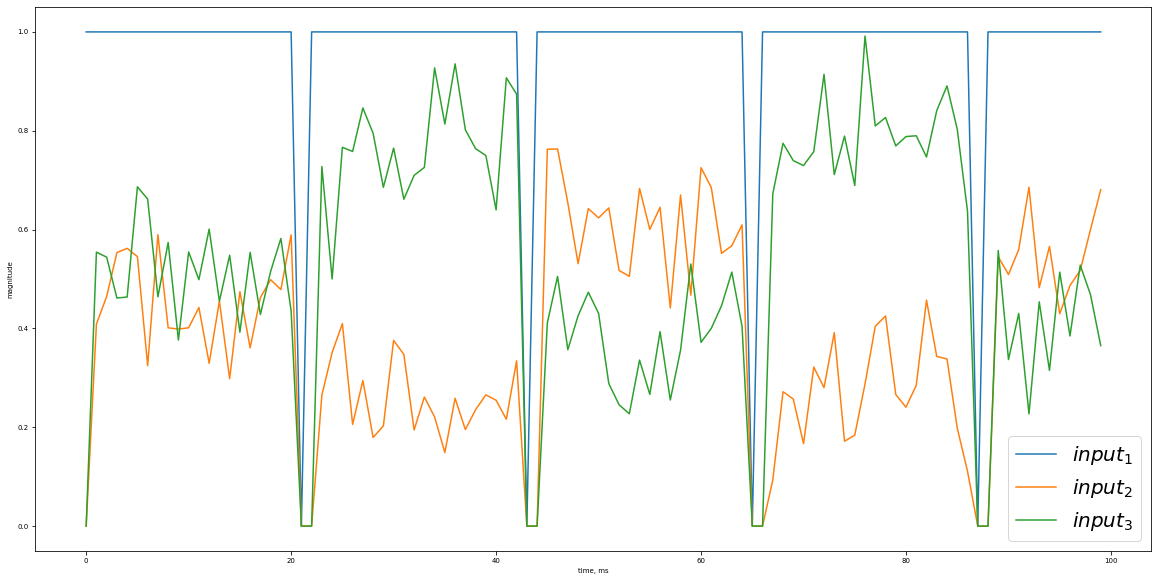

Text(0, 0.5, 'label')

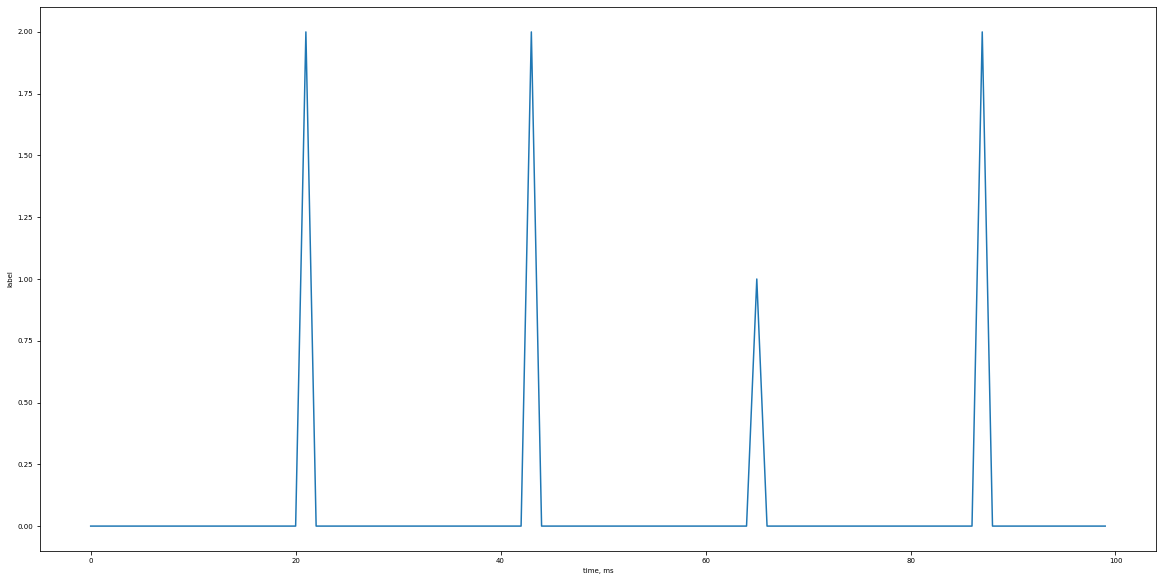

In [9]:
inputs, labels = dataset()
print(f'inputs.shape = {inputs.shape}\nlabels.shape = {labels.shape}')
plt.figure(figsize=(20, 10))
for i in range(ob_size):
    plt.plot(inputs[:, 0, i], label=f'$input_{i + 1}$')
plt.legend(fontsize=20)
plt.xlabel('time, ms')
plt.ylabel('magnitude')
plt.show()
plt.close()


plt.figure(figsize=(20, 10))
plt.plot(labels[:, 0])
plt.xlabel('time, ms')
plt.ylabel('label')

In [10]:

import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import norse
import norse.torch as snn
from tqdm import tqdm

device = torch.device('cuda')


@torch.jit.script
def _exp_filter_step_jit(
    old_value: torch.Tensor,
    input_value: torch.Tensor,
    parameter: float) -> torch.Tensor:
    value_new = parameter * old_value + input_value
    return value_new

def exp_filter_step(old_value: torch.Tensor,
    input_value: torch.Tensor,
    parameter: float) -> torch.Tensor:
    
    
    return _exp_filter_step_jit(old_value, input_value, parameter)
class SNNtest(torch.nn.Module):
    def __init__(self, input_size, output_size,  hidden_size = 100) -> None:
        super(SNNtest, self).__init__()
        self.lif = snn.LIFRecurrent(input_size, hidden_size)
        #if input_weights:
        self.linear = nn.Linear(hidden_size, output_size)
        #else:
            #self.linear = nn.Linear(hidden_size, output_size, bias=False)
        
    def forward(self, x):
        #out = self.linear_in(x)
        out, _ = self.lif(x)
        out = self.linear(out)
        return out

hidden_size = 100
input_weights = torch.rand(ob_size, hidden_size).T.to(device) 
with torch.no_grad():
    input_weights = -1 + 2 * input_weights 
    input_weights *= 2
    
model = SNNtest(ob_size, act_size, hidden_size=hidden_size).to(device)
for name, param in model.named_parameters():
    if name == 'lif.recurrent_weights':
        prev_weights =param * 1
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


running_loss = 0.0
for i in (range(2000)):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    
    loss = criterion(outputs.view(-1, act_size), labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 100))
        running_loss = 0.0
        
        with torch.no_grad():
            perf = 0
            num_trial = 100
            for i in (range(num_trial)):
                env.new_trial()
                ob, gt = env.ob, env.gt
                ob = ob[:, np.newaxis, :]  # Add batch axis
                inputs = torch.from_numpy(ob).type(torch.float).to(device)

                action_pred = model(inputs)
                action_pred = torch.argmax(action_pred, axis=-1)
                perf += gt[-1] == action_pred[-1, 0].cpu().item()
                

            perf /= num_trial
            print(f'Average performance in {num_trial:d} trials = {perf:.4f}')
            print()

print('Finished Training')

for name, param in model.named_parameters():
    if name == 'lif.recurrent_weights':
        post_weights = param * 1
    

KeyboardInterrupt: 

In [11]:
inputs.size()

torch.Size([100, 110, 3])

In [ ]:

from tqdm import tqdm 


100%|██████████| 500/500 [00:01<00:00, 345.42it/s]

Average performance in 500 trials
0.4340


In [ ]:
for name, param in model.named_parameters():
    if name == 'lif.recurrent_weights':
        post_weights = param * 1

linear_in.weight torch.Size([100, 3])


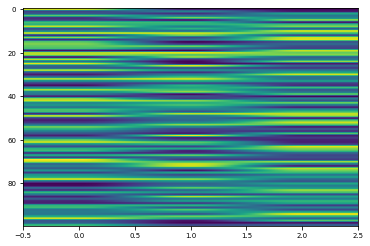

lif.input_weights torch.Size([100, 100])


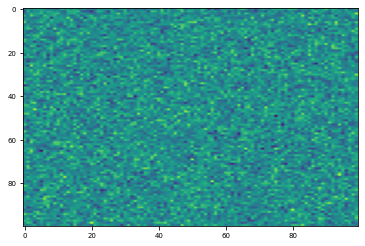

lif.recurrent_weights torch.Size([100, 100])


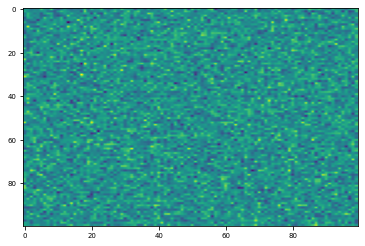

linear.weight torch.Size([3, 100])


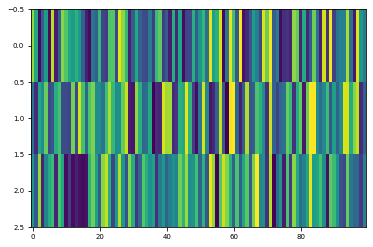

In [ ]:
for name, param in model.named_parameters():
    if (name != 'linear.bias' and name != 'linear_in.bias'):
        print(name, param.size())
        plt.imshow(param.detach().cpu().numpy(), aspect='auto')
        plt.show()
        plt.close()


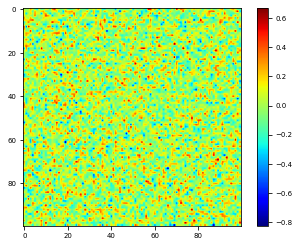

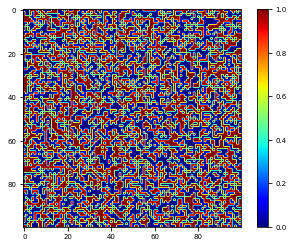

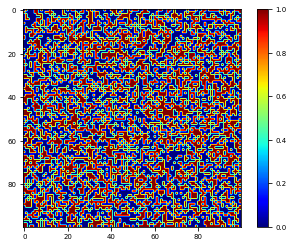

In [ ]:

with torch.no_grad():
    plt.imshow((prev_weights - post_weights).cpu().numpy(), cmap='jet')
    plt.colorbar() 
    plt.show()
    plt.close()
    

with torch.no_grad():
    plt.imshow((prev_weights).cpu().numpy() > 0, cmap='jet')
    plt.colorbar() 
    plt.show()
    
with torch.no_grad():
    plt.imshow((post_weights).cpu().numpy() > 0, cmap='jet')
    plt.colorbar() 
    plt.show()

In [ ]:
for name, param in model.named_parameters():
    print(name)
    if name == 'lif.recurrent_weights':
        post_weights = param * 1

linear_in.weight
linear_in.bias
lif.input_weights
lif.recurrent_weights
linear.weight
linear.bias


In [ ]:
with torch.no_grad():
    print((prev_weights - post_weights) != 0).nonzero(as_tuple=True)

tensor([[False,  True, False,  ...,  True,  True, False],
        [ True, False, False,  ...,  True,  True, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [ True,  True, False,  ...,  True, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')


AttributeError: 'NoneType' object has no attribute 'nonzero'

In [ ]:
with torch.no_grad():
    print(((prev_weights - post_weights) != 0).nonzero(as_tuple=True))

(tensor([ 0,  0,  0,  ..., 99, 99, 99], device='cuda:0'), tensor([ 1,  3,  6,  ..., 30, 59, 78], device='cuda:0'))


In [ ]:
for name, param in model.named_parameters():
    print(f'name:{name}')

name:linear_in.weight
name:linear_in.bias
name:lif.input_weights
name:lif.recurrent_weights
name:linear.weight
name:linear.bias


In [ ]:
for name, param in model.named_parameters():
    print(f'name:{name}')

name:lif.recurrent_weights
name:linear.weight
name:linear.bias


In [ ]:
import neurogym as ngym 
# Enviroment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 200 # times
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=100,
                       seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n
inputs, labels = dataset()
indexes_positive = np.argwhere(labels != 0)
indexes_positive[0]


array([21,  0])

  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: could not broadcast input array from shape (100,) into shape (0,)

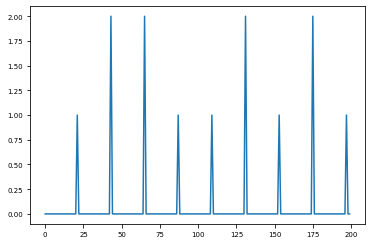

In [ ]:

import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import norse
import norse.torch as snn
from tqdm import tqdm

device = torch.device('cuda')

class SNNtest(torch.nn.Module):
    def __init__(self, input_size, output_size, input_weights, hidden_size = 100) -> None:
        super(SNNtest, self).__init__()
        self.lif = snn.LIFRecurrent(input_size, hidden_size, input_weights=input_weights)
        #if input_weights:
        self.linear = nn.Linear(hidden_size, output_size)
        #else:
            #self.linear = nn.Linear(hidden_size, output_size, bias=False)
        
    def forward(self, x):
        out, _ = self.lif(x)
        out = self.linear(out)
        return out

hidden_size = 1000
input_weights = torch.rand(ob_size, hidden_size, requires_grad=True).T.to(device) 
#with torch.no_grad():
    #input_weights = -1 + 2 * input_weights 
    #input_weights *= 1
model = SNNtest(ob_size, act_size, input_weights=input_weights, hidden_size=hidden_size).to(device)
for name, param in model.named_parameters():
    if name == 'lif.recurrent_weights':
        prev_weights =param * 1
learning_rate = 1e-1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#norse.torch.functional.super_fn

inputs, labels = dataset()
#plt.plot(inputs[:, 0, 0])
#plt.plot(inputs[:, 0, 1])
#plt.plot(inputs[:, 0, 2])
plt.plot(labels[:, 0])
labels_new = labels * 1
indexes_positive = np.argwhere(labels_new != 0)




inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
learning_outputs = model(inputs)

running_loss = 0.0
kappa = torch.exp(torch.tensor(-1/5, dtype=torch.float32))
for i in tqdm(range(1000)):
    inputs, labels = dataset()
    indexes_positive = np.argwhere(labels != 0)
    for j in range(1, len(indexes_positive)):
        prev_index = indexes_positive[j - 1][0]
        curent_index = indexes_positive[j][0]
        labels[prev_index:curent_index, 0] =  labels[curent_index]# one dim 
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
    with torch.no_grad():
        learning_outputs[:, :, (labels.cpu().numpy() - 1) ] = 1
        learning_outputs[:, :, 0] = inputs[:, :, 0] 
    learning_outputs = learning_outputs.detach()
        #learning_outputs[]

    

    # forward + backward + optimize
    outputs = model(inputs)
    
    loss = criterion(outputs, learning_outputs)
    loss.backward()
    optimizer.step()
    # zero the parameter gradients
    optimizer.zero_grad()
    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
        print('yes')
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 100))
        running_loss = 0.0

print('Finished Training')

for name, param in model.named_parameters():
    if name == 'lif.recurrent_weights':
        post_weights = param * 1
    

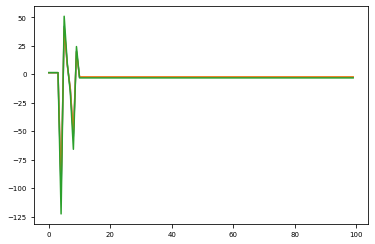

In [ ]:
outputs_for_plot = outputs.detach().cpu().numpy()
plt.plot(outputs_for_plot[:, 0, 0])
plt.plot(outputs_for_plot[:, 0, 1])
plt.plot(outputs_for_plot[:, 0, 2])

In [ ]:
inputs.shape

torch.Size([500, 1, 3])

tensor([[[-0.7591, -0.7591, -0.7591,  ..., -0.7591, -0.7591, -0.7591]],

        [[-0.7591, -0.7591, -0.7591,  ..., -0.7591, -0.7591, -0.7591]],

        [[-0.7591, -0.7591, -0.7591,  ..., -0.7591, -0.7591, -0.7591]],

        ...,

        [[-1.3100, -1.3100, -1.3100,  ..., -1.3100, -1.3100, -1.3100]],

        [[-1.2874, -1.2874, -1.2874,  ..., -1.2874, -1.2874, -1.2874]],

        [[-1.3927, -1.3927, -1.3927,  ..., -1.3927, -1.3927, -1.3927]]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [ ]:
inputs.shape

torch.Size([500, 1, 3])

In [ ]:
inputs, labels = dataset()
print(f'size labels = {labels.shape}')
for i in range(labels.shape[1]):
    if (labels[:, i] == 1).index()


size labels = (100, 160)


In [ ]:
print(f'size labels = {labels.shape}')


size labels = (100, 160)


In [ ]:
(labels[21, :] == 1)

array([ True,  True, False, False, False,  True, False, False, False,
        True,  True, False, False,  True, False,  True,  True, False,
        True, False, False,  True, False, False,  True, False, False,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False, False,  True,  True,  True,  True, False,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
       False, False,  True, False,  True,  True, False, False, False,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False, False,  True, False,  True,  True,
       False, False,  True,  True,  True, False,  True,  True, False,
       False,  True, False,  True,  True,  True, False, False,  True,
        True, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False,  True,

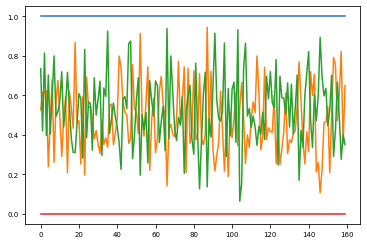

In [ ]:
index = 26

plt.plot(inputs[index, :, 0])
plt.plot(inputs[index, :, 1])
plt.plot(inputs[index, :, 2])
plt.plot(labels[index, :])

In [ ]:
import neurogym as ngym 
# Enviroment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100 # times
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=1,
                       seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n




inputs.shape = (100, 1, 3)
 labels.shape = (100, 1)


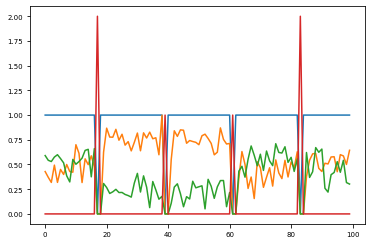

In [ ]:

inputs, labels = dataset()
print(f'inputs.shape = {inputs.shape}\n labels.shape = {labels.shape}')

plt.plot(inputs[:, 0, 0])
plt.plot(inputs[:, 0, 1])
plt.plot(inputs[:, 0, 2])
plt.plot(labels[:, 0])

torch.Size([500, 1, 3])

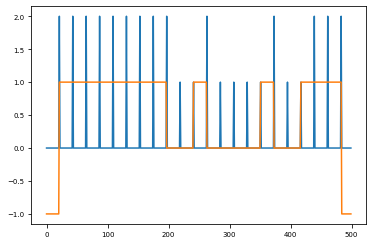

In [ ]:

import neurogym as ngym 
# Enviroment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 500 # times
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=1,
                       seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n
inputs, labels = dataset()
#plt.plot(inputs[:, 0, 0])
#plt.plot(inputs[:, 0, 1])
#plt.plot(inputs[:, 0, 2])
plt.plot(labels[:, 0])
labels_new = labels * 1
indexes_positive = np.argwhere(labels_new != 0)
for i in range(1, len(indexes_positive)):
    prev_index = indexes_positive[i - 1][0]
    curent_index = indexes_positive[i][0]
    labels_new[prev_index:curent_index, 0] =  labels_new[curent_index]# one dim 
plt.plot(labels_new[:, 0] - 1)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)

outputs = model(inputs)
outputs.size()

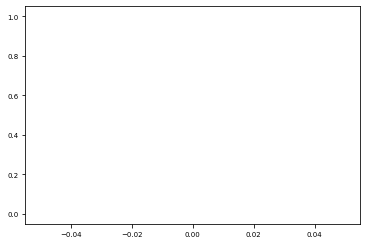

In [ ]:

index = 0

plt.plot(inputs[index, :, 0])
plt.plot(inputs[index, :, 1])
plt.plot(inputs[index, :, 2])
plt.plot(labels[index, :])

In [ ]:
labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

(100, 1)